In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:

xi= np.array([0.8])
lamb =  np.array([1])
t_final = 4000
t_initial = 0
delta_t = 0.001
time = np.arange(t_initial, t_final , delta_t)

In [3]:
X11=np.loadtxt('1D_jump.dat')

In [4]:
X112=X11[0:100000]
time1=time[0:100000]

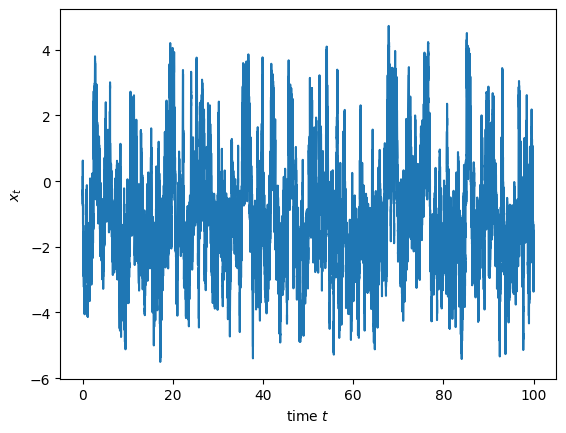

In [5]:
#This is the stochastic trajectory over time
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib auto
plt.figure(0)#,dpi=800
plt.plot(time1, X112)#, label = r'The trajectory of 1D jump diffusion process'
plt.xlabel(r'time $t$')
plt.ylabel(r'$x_t$')
plt.show(block = True)

In [6]:
from kmc import KM
bins = np.array([950])
powers = np.array([[0], [1], [2], [3], [4], [5], [6]])
kmcs,edge=KM(X11, powers = powers,bins=bins,correction=True)

In [7]:
from kramersmoyal import km
bins = np.array([950])
powers = np.array([[0], [1], [2], [3], [4], [5], [6]])
bw =None
moments, edges = km(X11, bw=bw, bins=bins, powers=powers)

In [8]:


edges=np.squeeze(np.array(edges))

tol= 1e-8
D0_=kmcs[0,:]
mask1 =abs(D0_ ) < tol
D6_=kmcs[6,~mask1]
D4_=kmcs[4,~mask1]
D0_=kmcs[0,~mask1]

temp = (D6_) / (5 * D4_)
xi_est1 = np.average(temp, weights = D0_)
xi_est1_std= np.abs(xi-xi_est1)
print('xi_est1',xi_est1)
print('xi_est1_std',xi_est1_std)


temp = (D4_) / (3 * (xi_est1**2) )
lamb_est1 = np.average(temp, weights = D0_)
lamb_est1=lamb_est1/delta_t
lamb_est1_std = np.abs(lamb-lamb_est1)
print('lamb_est1:',lamb_est1)
print('lamb_est1_std:',lamb_est1_std)

xi_est1 0.7930015769818937
xi_est1_std [0.00699842]
lamb_est1: 0.9683327354108482
lamb_est1_std: [0.03166726]


In [10]:

edges=np.squeeze(np.array(edges))

tol= 1e-8
D0=moments[0,:]
mask1 =abs(D0 ) < tol
D6=moments[6,~mask1]
D4=moments[4,~mask1]
D0=moments[0,~mask1]

temp = (D6) / (5 * D4)
xi_est = np.average(temp, weights = D0)
xi_est_std= np.abs(xi-xi_est)
print('xi_est',xi_est)
print('xi_est_std',xi_est_std)


temp = (D4) / (3 * (xi_est**2) )
lamb_est = np.average(temp, weights = D0)
lamb_est=lamb_est/delta_t
lamb_est_std = np.abs(lamb-lamb_est)
print('lamb_est:',lamb_est)
print('lamb_est_std:',lamb_est_std)

xi_est 0.015628636038012355
xi_est_std [0.78437136]
lamb_est: 199.69270164082454
lamb_est_std: [198.69270164]


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_4400\3191653436.py:7: RuntimeWarning: invalid value encountered in sqrt
  D2=np.sqrt(2*moments[2,:]/delta_t-lamb_est*xi_est)*np.sign(moments[2,:]/delta_t-lamb_est*xi_est)


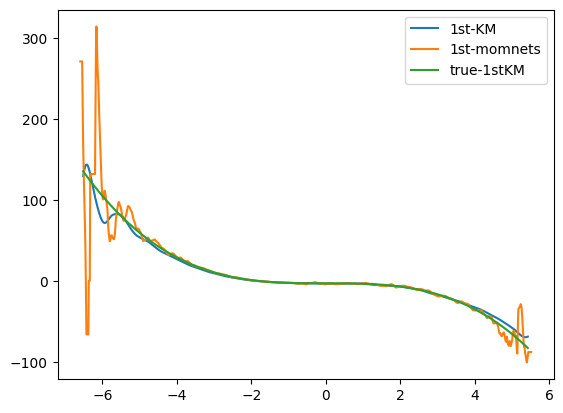

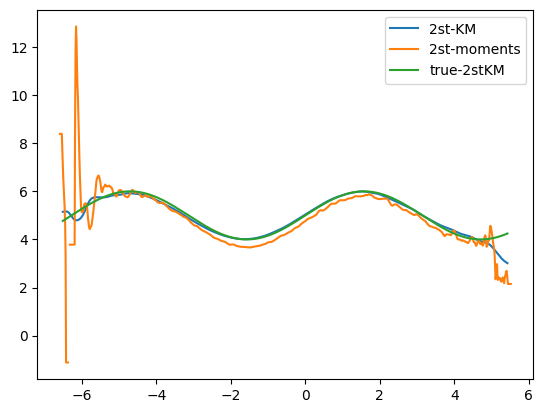

In [12]:

D1_=kmcs[1,:]/delta_t
D2_=np.sqrt(kmcs[2,:]/delta_t-lamb_est1*xi_est1)
ax_=-0.5*edge**3-3
bx_=((np.sin(edge))+5)

D1=moments[1,:]/delta_t
D2=np.sqrt(2*moments[2,:]/delta_t-lamb_est*xi_est)*np.sign(moments[2,:]/delta_t-lamb_est*xi_est)
ax=-0.5*edges**3-3
bx=((np.sin(edges))+5)

# %matplotlib auto
%matplotlib inline
plt.figure(9)
plt.plot(edge, D1_,label='1st-KM')
plt.plot(edges, D1,label='1st-momnets')
plt.plot(edge,ax_,label='true-1stKM')
plt.legend()
plt.figure(10)
plt.plot(edge,D2_,label="2st-KM")
plt.plot(edges,D2,label="2st-moments")
plt.plot(edge,bx_,label='true-2stKM')
plt.legend()
plt.show(block = True)

In [13]:
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

def library(x,librarystyle):
    # x1, x2 = x[:, 0], x[:, 1]
    # return np.transpose([np.ones_like(x1), x1, x2, x1**2, x2**2, x1*x2, np.abs(x1-x2), np.abs(x1+x2)])
    x[np.isnan(x)]=0
    if librarystyle == 'poly_library':
        poly = PolynomialFeatures(degree=3,include_bias=True).fit(x)
        X_poly = poly.fit_transform(x)
        clumns_list = poly.get_feature_names_out()
        Theta=X_poly
        print(clumns_list)
    elif librarystyle == 'fourier_library':
        Theta=np.hstack([np.sin(x),np.cos(x)])
        print('sin(x)','cos(x)')
    elif librarystyle == 'generalized_library':
        poly = PolynomialFeatures(degree=3,include_bias=True).fit(x)
        X_poly = poly.fit_transform(x)
        clumns_list = poly.get_feature_names_out()
        Theta=X_poly
        print(clumns_list,'sin(x)','cos(x)')
        Theta=np.hstack([X_poly, np.sin(x),np.cos(x)])
    
    return Theta

def sparse_regression(X, y):
    model = Lasso(alpha=0.00001, fit_intercept=False, max_iter=100000)
    model.fit(X, y)
    return model.coef_,model.intercept_

def SINDy(X, dx, librarystyle:str,threshold=0.4):
    # pool data & compute library
    Theta = library(X,librarystyle)
    for i in range(Theta.shape[1]):
        Xi,intercept_ = sparse_regression(Theta, dx)
        # thresholding
        small_idx = np.abs(Xi) < threshold
        Xi[small_idx] = 0
        Theta[:,small_idx]=0
    return Xi

Xii1= SINDy(edge.reshape(-1,1), D1_.reshape(-1,1),librarystyle='poly_library')
print(Xii1)
Xii2= SINDy(edge.reshape(-1,1), D2_.reshape(-1,1),librarystyle='generalized_library')
print(Xii2)

['1' 'x0' 'x0^2' 'x0^3']
[-3.00486673  0.          0.         -0.45922216]
['1' 'x0' 'x0^2' 'x0^3'] sin(x) cos(x)
[4.95094695 0.         0.         0.         1.01511264 0.        ]
